# COMPOSITIONAL ANALYSIS

# Python packages

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import scanpy as sc
import numpy as np
import tensorflow as tf
from modules.visualize import *
from modules.deg_analysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pertpy as pt
from collections import Counter
import scvi
import anndata
import matplotlib

2024-08-17 17:56:22.803545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 17:56:23.316018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'A_WT-DMSO',
                      'SampleTag18_flex':'B_3xTg-DMSO',
                      'SampleTag19_flex':'C_WT-SCDi',
                      'SampleTag20_flex':'D_3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}

In [ ]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

# adata = anndata.read_h5ad('data/fede_data/scdi_hypothalamus_count.h5ad')
# anno_df = pd.read_csv("data/fede_data/scdi_hypothalamus_mapping.csv", skiprows=4)
# adata = annotate_adata(adata, anno_df)

In [ ]:
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

In [ ]:
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]
adata = adata[adata.obs['Sample_Tag'] != "Undetermined", :]

# Generate pseudoreplicates

In [5]:
# Convert 'Sample_Tag' to string if it's not already
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].astype(str)

# Create a new 'batch' column based on 'Sample_Tag'
adata.obs['batch'] = adata.obs['Sample_Tag'].astype(str)

# Get the unique sample tags
unique_sample_tags = adata.obs['Sample_Tag'].unique()

# Create new batch labels
new_batch_labels = []
for sample_tag in unique_sample_tags:
    new_batch_labels.extend([f"{sample_tag}_1", f"{sample_tag}_2", f"{sample_tag}_3"])

# Update the categories to include the new batch labels
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.add_categories(new_batch_labels)

# Loop over each unique sample tag and assign pseudoreplicates
for sample_tag in unique_sample_tags:
    # Get the indices for the current sample tag
    indices = adata.obs[adata.obs['Sample_Tag'] == sample_tag].index
    
    # Assign pseudoreplicates randomly
    n = len(indices)
    replicate_labels = np.random.choice([f"{sample_tag}_1", f"{sample_tag}_2", f"{sample_tag}_3"], size=n)
    
    # Update the batch column with these pseudoreplicate labels
    adata.obs.loc[indices, 'batch'] = replicate_labels

# Filter out low frequency cell type

In [6]:
class_counts = adata.obs['subclass_name'].value_counts()
valid_classes = class_counts[class_counts >= 50].index
adata = adata[adata.obs['subclass_name'].isin(valid_classes)].copy()

# Cell type abundances histogram

In [ ]:
# Assuming 'adata.obs' is your DataFrame
df = adata.obs[['total_counts', 'Sample_Tag', 'subclass_name']]

# Aggregate the data to get the number of cells per cell type
cell_type_counts = df['subclass_name'].value_counts()

# Filter out cell types with less than 100 cells
filtered_cell_types = cell_type_counts[cell_type_counts >= 100].index

# Filter the original DataFrame
filtered_df = df[df['subclass_name'].isin(filtered_cell_types)]

# Pivot the DataFrame to get the number of cells instead of total counts
pivot_df = filtered_df.groupby(['Sample_Tag', 'subclass_name']).size().unstack(fill_value=0)

# Resetting the index
pivot_df.reset_index(inplace=True)

# Melting the DataFrame to long format
plot_data_global = pivot_df.melt(id_vars="Sample_Tag", var_name="Cell type", value_name="count")

# Renaming 'Sample_Tag' to 'Condition' to match the plot example
plot_data_global.rename(columns={'Sample_Tag': 'Condition'}, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Filtered DataFrame for plotting to ensure legends and data match
filtered_plot_data_global = plot_data_global[
    plot_data_global['Cell type'].isin(filtered_cell_types)
]

# Plot for Global abundances, by condition
sns.barplot(
    data=filtered_plot_data_global, x="Condition", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Abundances, by condition")
ax[0].legend(title="Cell type", loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for Global abundances, by cell type
sns.barplot(
    data=filtered_plot_data_global, x="Cell type", y="count", hue="Condition", ax=ax[1]
)
ax[1].set_title("Abundances, by cell type")
ax[1].legend(title="Condition", loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis labels of the right plot
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('figures/cell_type_abundances.png',bbox_inches='tight')
plt.show()

# Compositional analysis

In [7]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="subclass_name",
    sample_identifier="batch",
    covariate_obs=["Sample_Tag"],
)

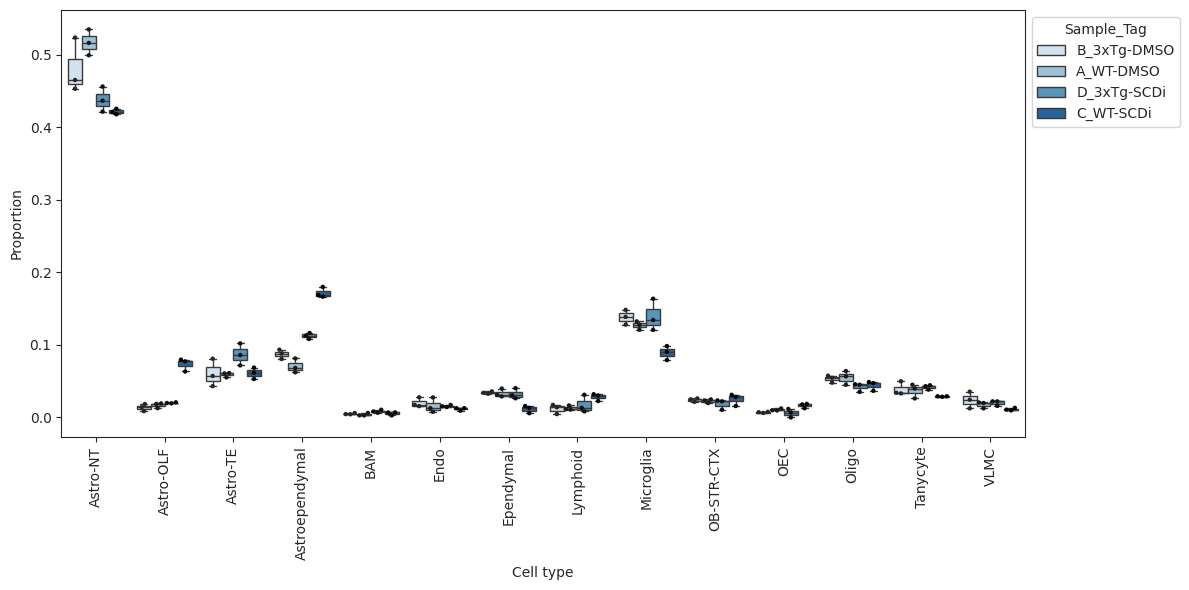

In [8]:
ax = pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="Sample_Tag",
    figsize=(12, 6),
    add_dots=True,
)

# Adjust the dot size if possible
for collection in ax.collections:
    if isinstance(collection, matplotlib.collections.PathCollection):
        collection.set_sizes([10])  # Adjust this value to make dots smaller

plt.tight_layout()
plt.savefig('figures/coda_boxplots.png', bbox_inches='tight')
plt.show()

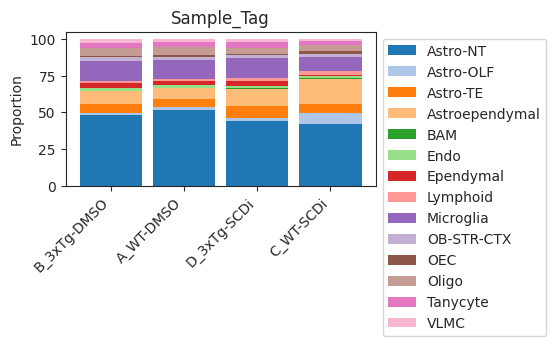

In [9]:
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="Sample_Tag", figsize=(4, 2)
)
plt.tight_layout()
plt.savefig('figures/coda_stacked_barplot.png',bbox_inches='tight')
plt.show()

In [10]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Sample_Tag",
    reference_cell_type="automatic",
)

Automatic reference selection! Reference cell type set to BAM

Zero counts encountered in data! Added a pseudocount of 0.5.

In [11]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|█| 11000/11000 [16:25<00:00, 11.17it/s, 255 steps of size 1.05e-02.


In [17]:
sccoda_model.set_fdr(sccoda_data, 0.05)

In [18]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                  Cell Type     
Sample_Tag[T.B_3xTg-DMSO]  Astro-NT           True
                           Astro-OLF          True
                           Astro-TE           True
                           Astroependymal     True
                           BAM               False
                           Endo               True
                           Ependymal          True
                           Lymphoid           True
                           Microglia          True
                           OB-STR-CTX         True
                           OEC                True
                           Oligo              True
                           Tanycyte           True
                           VLMC               True
Sample_Tag[T.C_WT-SCDi]    Astro-NT           True
                           Astro-OLF          True
                           Astro-TE           True
                           Astroependymal     True
                           BAM          

In [19]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda")

# Converting the credible_effects to a pandas DataFrame
credible_effects_df = pd.DataFrame(credible_effects)
print(credible_effects_df)

                                          Final Parameter
Covariate                 Cell Type                      
Sample_Tag[T.B_3xTg-DMSO] Astro-NT                   True
                          Astro-OLF                  True
                          Astro-TE                   True
                          Astroependymal             True
                          BAM                       False
                          Endo                       True
                          Ependymal                  True
                          Lymphoid                   True
                          Microglia                  True
                          OB-STR-CTX                 True
                          OEC                        True
                          Oligo                      True
                          Tanycyte                   True
                          VLMC                       True
Sample_Tag[T.C_WT-SCDi]   Astro-NT                   True
              

In [20]:
credible_effects_df

Final Parameter
Covariate                 Cell Type                      
Sample_Tag[T.B_3xTg-DMSO] Astro-NT                   True
                          Astro-OLF                  True
                          Astro-TE                   True
                          Astroependymal             True
                          BAM                       False
                          Endo                       True
                          Ependymal                  True
                          Lymphoid                   True
                          Microglia                  True
                          OB-STR-CTX                 True
                          OEC                        True
                          Oligo                      True
                          Tanycyte                   True
                          VLMC                       True
Sample_Tag[T.C_WT-SCDi]   Astro-NT                   True
                          Astro-OLF                  True
                          Astro-TE                   True
                          Astroependymal             True
                          BAM                       False
                          Endo                       True
                          Ependymal                  True
                          Lymphoid                   True
                          Microglia                  True
                          OB-STR-CTX                 True
                          OEC                        True
                          Oligo                      True
                          Tanycyte                   True
                          VLMC                       True
Sample_Tag[T.D_3xTg-SCDi] Astro-NT                   True
                          Astro-OLF                  True
                          Astro-TE                   True
                          Astroependymal             True
                          BAM                       False
                          Endo                       True
                          Ependymal                  True
                          Lymphoid                   True
                          Microglia                  True
                          OB-STR-CTX                 True
                          OEC                        True
                          Oligo                      True
                          Tanycyte                   True
                          VLMC                       True

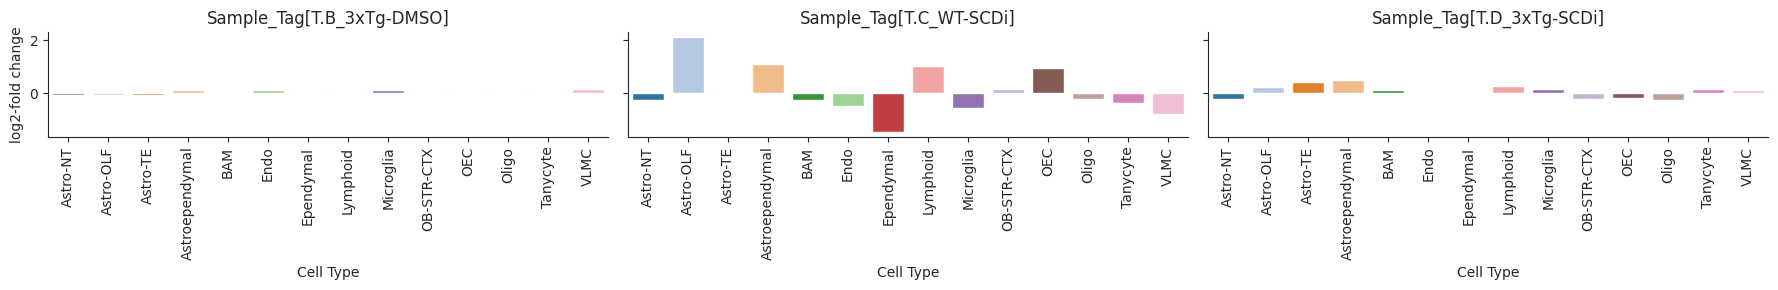

In [21]:
pt.pl.coda.effects_barplot(sccoda_data, "coda", "Sample_Tag")
plt.tight_layout()
plt.savefig('figures/coda_effects_barplot.png', bbox_inches='tight')
plt.show()